# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 07.06.2024**

**Мягкий дедлайн: 23.06.2024 23:59 MSK**

**Жёсткий дедлайн: 23.06.2024 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.txt')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.txt')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [4]:
def pr_k(relevant: List[int], pred: List[int], k: int = 20) -> float:
  pr = 0
  for i in range(k):
    if pred[i] in relevant:
      pr += 1
  return pr / k

def ap_k(relevant: List[int], pred: List[int], k: int = 20) -> float:
  ap = 0
  for i in range(k):
    if pred[i] in relevant:
      ap += pr_k(relevant, pred, i + 1)
  return ap / min(k, len(relevant))


def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20) -> float:
  map = 0
  for rel, pred in zip(relevant, predicted):
    map += ap_k(rel, pred, k)
  return map / len(relevant)

In [ ]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [5]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [6]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [7]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [8]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [9]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [ ]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [56]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [57]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for uid in range(self.n_users):
          test_preds.append(self.recommend(uid))

        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [58]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    intersetion = ratings @ user_vector # n_users
    union = (ratings + user_vector).sum(axis=1) - intersetion
    return intersetion / union

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [59]:
class User2User(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        sim = self.similarity(self.R[uid])
        sim[uid] = 0 # чтобы себя не воспринимать как похожего
        Nu_indices = np.where(sim > self.alpha)[0]
        Nu_ratings = self.R[Nu_indices]
        Nu_sim = sim[Nu_indices]

        r_uid = (Nu_sim @ Nu_ratings)  / Nu_sim.sum()

        return np.argsort(r_uid)[::-1]
        pass

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

In [ ]:
u2u = User2User(train_ratings)
u2u_recs = u2u.get_test_recommendations(100)
popular_recs = np.argsort(u2u.R.sum(axis=0) * -1) * np.ones((u2u.n_users, u2u.n_items))
k_n = (1, 4, 8, 10, 15, 30)
metrics_u2u = []
metrics_popular = []
metrics_random = []
best_mapk_u2u = 0

for k in k_n:
  recs_u2u_k = u2u_recs[:, : k]
  recs_popular_k = popular_recs[:, : k]
  recs_random_k = np.random.choice(u2u.n_items, size=(u2u.n_users, k))
  metrics_u2u.append(mapk(test_relevant, recs_u2u_k.tolist(), k))
  metrics_popular.append(mapk(test_relevant, recs_popular_k[test_users].tolist(), k))
  metrics_random.append(mapk(test_relevant, recs_random_k[test_users].tolist(), k))

  if best_mapk_u2u < mapk(test_relevant, recs_u2u_k.tolist(), k):
    best_mapk_u2u = mapk(test_relevant, recs_u2u_k.tolist(), k)



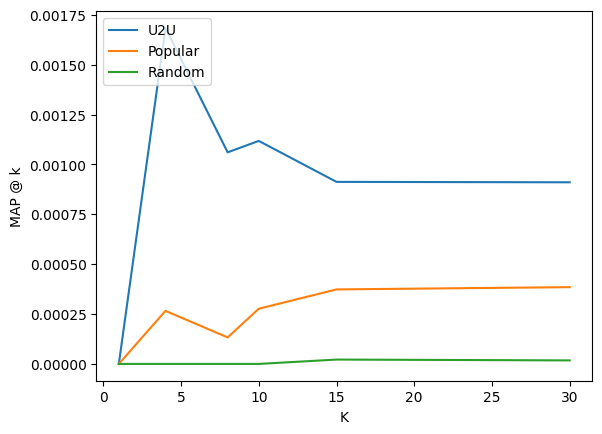

In [ ]:
plt.plot(k_n, metrics_u2u)
plt.plot(k_n, metrics_popular)
plt.plot(k_n, metrics_random)
plt.legend(['U2U','Popular','Random'], loc=2)
plt.xlabel('K')
plt.ylabel('MAP @ k')
plt.show()

Неудивительно, что лучшим оказался u2u метод с мерой Жаккара, популярные треки показали гораздо хуже качество, рандомные в самом низу.

**Бонус (1 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [ ]:
# your code here: ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [ ]:
user_id = np.random.randint(0, u2u.n_users)

In [ ]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
175,Lollipop,"['Lil Wayne', 'Static Major']"
298,I Wanna Love You,"['Akon', 'Snoop Dogg']"
449,Disco Inferno,['50 Cent']
952,Still D.R.E.,"['Dr. Dre', 'Snoop Dogg']"
1429,Dilemma,"['Nelly', 'Kelly Rowland']"
2321,Satisfy You,"['P. Diddy', 'R. Kelly']"
2329,Me & U,['Cassie']
2948,7 Days,['Craig David']
3058,Low,"['Flo Rida', 'T-Pain']"
3237,Crank That (Soulja Boy),['Soulja Boy']


In [ ]:
preds = u2u.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

<ipython-input-28-c005c2d731c5>:21: RuntimeWarning: divide by zero encountered in divide
  r_uid = (Nu_sim @ Nu_ratings)  / Nu_sim.sum()
<ipython-input-28-c005c2d731c5>:21: RuntimeWarning: invalid value encountered in divide
  r_uid = (Nu_sim @ Nu_ratings)  / Nu_sim.sum()


Predicted tracks:


,name,artists
18459,Take Me To Church,['Hozier']
8263,Shape Of My Heart,['Sting']
34598,Равнодушие,"['МАЛЬБЭК', 'Сюзанна']"
24500,Way Down We Go,['KALEO']
38212,Горы по колено,['Макс Корж']
6136,Billie Jean,['Michael Jackson']
41960,Yeah Right,['Joji']
53925,Молчи,['кис-кис']
12266,Radioactive,['Imagine Dragons']
42330,Fukk Sleep,"['A$AP Rocky', 'FKA twigs']"


In [ ]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
62134,Pretty Boy,"['Joji', 'Lil Yachty']"
62158,Чёрный мерин,['Navai']
62159,Милая моя,"['Navai', 'Эллаи']"
62988,Запомни I love you,"['SHAMI', 'Rauf & Faik']"
63383,Девочка танцуй,['HammAli & Navai']
63566,Чистый,['Скриптонит']
63781,"Салют, Вера",['Mona Songz']
64362,Лилии,"['JONY', 'MOT']"
64975,Dragon,"['Andro', 'Скриптонит']"
65018,i love u girl.,"['poofi.', 'Shiloh']"


В каком-то плане точно есть походие треки, например, наличие российских исполнителей, однако до настоящего качества еще, к сожалению, далеко...

### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**SGD:**

Короче тут можем просто считать в зависимости от попавшегося рейтинга из матрицы с явной информацией. Вот нам попался $$r_{ui}$$, тогда функционал будет примерно таким: $$(\langle p_u, q_i \rangle - r_{ui})^2 + \lambda \left( \|p_u\|^2 + \|q_i\|^2\right) \rightarrow \displaystyle\min_{p_u, q_i}$$
это расписывается более подробно примерно так:
$$(p_{u1}q_{i1} + ... +p_{uD}q_{iD} - r_{ui})^2 + \lambda \left(p_{u1}^2 + ... + p_{uD}^2 + q_{i1}^2 + ... +q_{iD}^2 \right) \rightarrow \displaystyle\min_{p_u, q_i}$$
D - размерность скрытого пространства

Далее просто из этой формулы надо взять частную производную:

$$
\frac{\partial}{\partial p_{ud}} = 2 \cdot (q_{id} \cdot (q_{id} \cdot p_{ud} - r_{ui}) + \lambda p_{ud})
$$

$$
\frac{\partial}{\partial q_{id}} = 2 \cdot (p_{ud} \cdot (p_{ud} \cdot q_{id} - r_{ui}) + \lambda q_{id})
$$
И посчитать градиент:

$$
p_{ud} = p_{ud} - lr \cdot 2 \cdot (q_{id} \cdot (q_{id} \cdot p_{ud} - r_{ui}) + \lambda p_{ud})
$$

$$
q_{id} = q_{id} - lr \cdot 2 \cdot (p_{ud} \cdot (p_{ud} \cdot q_{id} - r_{ui}) + \lambda q_{id})
$$

ну и это вектороно можно легко посчитать...

**ALS:**

Здесь немного все по-другому, мы хотим обновлять параметры по отдельности, пробегаясь по всем $$r_{ui}$$
Сначала приведу пример обновления строго одного параметра, затем уже подпишу в векторном виде

Допустим хочу обновить $${p_{ud}}$$
Функционал будет примерно такой:
$$
\sum_{r_{ui} \in R} (p_{ud} \cdot q_{id} - r_{ui}) ^ 2 + \lambda \cdot p_{ud} ^ 2 \rightarrow \min_{p_{ud}}
$$


По этой темке берем производную и приравниваем к нулю, получаем вот так (при фиксированном u):

$$
p_{ud} = \frac {\sum_{r_{ui} \in R} r_{ui} \cdot q_{id}} {\sum_{r_{ui} \in R} q_{id} ^ 2 + \lambda}
$$
U, I - число юзеров и айтемов соответственно. Аналогично (при фиксированном i) зеркально получим для $$q_{id}$$

$$
q_{id} = \frac {\sum_{r_{ui} \in R} r_{ui} \cdot q_{id}} {\sum_{r_{ui} \in R} p_{ud} ^ 2 + \lambda}
$$

Теперь это все добро в векторном виде попробую фигануть (эта формула немного не точная, зато более понятная для реализации, она не учитывает, что мы не должны брать rui = 0):

$$
p_u = \frac{r_u * Q} {Q ^ 2.sum(ax = 0) + \lambda}
$$

$$
q_i = \frac {R[:, i].T * P}{P^2.sum(ax=1) + \lambda}
$$

Более праивльно, но менее понятнее для имплементации вот так:

$$
\begin{align*}
    &p_u
    =
    \left(
        \sum_{i: \exists r_{ui}}
            q_i q_i^T
    \right)^{-1}
    \sum_{i: \exists r_{ui}}
        r_{ui} q_i;\\
    &q_i
    =
    \left(
        \sum_{u: \exists r_{ui}}
            p_u p_u^T
    \right)^{-1}
    \sum_{u: \exists r_{ui}}
        r_{ui} p_u;\\
\end{align*}
$$


**Задание 7 (1.5 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [14]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':

              batch = self.ratings.iloc[np.random.randint(0, self.ratings.shape[0], 128)]
              batch.drop_duplicates(subset=['userId'], keep='first', inplace=True) # короче за один шаг sgd, надо чтобы каждый вектор обновлялся один раз, поэтому не дожны в шаге повторяться треки или юзеры
              batch.drop_duplicates(subset=['trackId'], keep='first', inplace=True)
              q = self.Q[batch['trackId']]
              p = self.P[batch['userId']]
              self.P[batch['userId']] -= self.lr * 2 * (q * (q * p - self.R[batch['userId'], batch['trackId']].reshape(-1, 1)) + self.lamb * p)
              self.Q[batch['trackId']] -= self.lr * (p * (p * q - self.R[batch['userId'], batch['trackId']].reshape(-1, 1)) + self.lamb * q)

            elif self.mode == 'als':
              self.P = (self.R @ self.Q) / ((self.Q ** 2).sum(axis=0) + np.ones(self.Q.shape[1],) * self.lamb)
              self.Q = (self.R.T @ self.P) / ((self.P ** 2).sum(axis=0) + np.ones(self.P.shape[1],) * self.lamb)
              pass

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [ ]:
n_iterations = (10, 100, 300, 500, 1000)
dims = np.arange(16, 257, 16)
best = 0
lfm_best = 0
best_k = []
best_dims = []
best_mapks_k = []
metrics_lfm_best = []
for i in n_iterations:
  for dim in dims:
    lfm = LatentFactorModel(train_ratings, dim, 'sgd')
    lfm.fit(i)
    lfm_recs = lfm.get_test_recommendations(100)
    mapk_i = 0
    metrics_lfm = []
    for k in k_n:
      recs_lfm_k = lfm_recs[:, : k]
      mapk_i += mapk(test_relevant, recs_lfm_k.tolist(), k)
      metrics_lfm.append(mapk(test_relevant, recs_lfm_k.tolist(), k))
      if mapk(test_relevant, recs_lfm_k.tolist(), k) > best_mapk_u2u:
        best_k.append(k)
        best_dims.append(dim)
        best_mapks_k.append(mapk(test_relevant, recs_lfm_k.tolist(), k))
    if mapk_i / len(k_n) > best:
      best = mapk_i / len(k_n)
      lfm_best = lfm
      metrics_lfm_best = metrics_lfm
      print(f'MAP: {best}, iters: {i}, dims: {dim}' )

  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-105-ecd88ce0face>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch.drop_duplicates(subset=['userId'], keep='first', inplace=True) # короче за один шаг sgd, надо чтобы каждый вектор обновлялся один раз, поэтому не дожны в шаге повторяться треки или юзеры
<ipython-input-105-ecd88ce0face>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch.drop_duplicates(subset=['trackId'], keep='first', inplace=True)


MAP: 0.00111870989530564, iters: 10, dims: 16


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

MAP: 0.0012537702779815765, iters: 100, dims: 112


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

MAP: 0.002379798083621704, iters: 1000, dims: 112


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Посмортим на k, рекомендации которых получились лучше U2U

In [ ]:
pd.DataFrame({'map': best_mapks_k, 'k': best_k, 'dim': best_dims})

,map,k,dim
0,0.004255,1,16
1,0.004255,1,112
2,0.004255,1,128
3,0.004255,1,48
4,0.004255,1,176
5,0.008511,1,112
6,0.002482,4,112
7,0.004255,1,224


In [ ]:
for_plot = []
for i in n_iterations:
  lfm = LatentFactorModel(train_ratings, 112, 'sgd')
  lfm.fit(i)
  lfm_recs = lfm.get_test_recommendations(1)
  for_plot.append(mapk(test_relevant, lfm_recs.tolist(), 1))

  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-105-ecd88ce0face>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch.drop_duplicates(subset=['userId'], keep='first', inplace=True) # короче за один шаг sgd, надо чтобы каждый вектор обновлялся один раз, поэтому не дожны в шаге повторяться треки или юзеры
<ipython-input-105-ecd88ce0face>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch.drop_duplicates(subset=['trackId'], keep='first', inplace=True)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'LFM SGD')

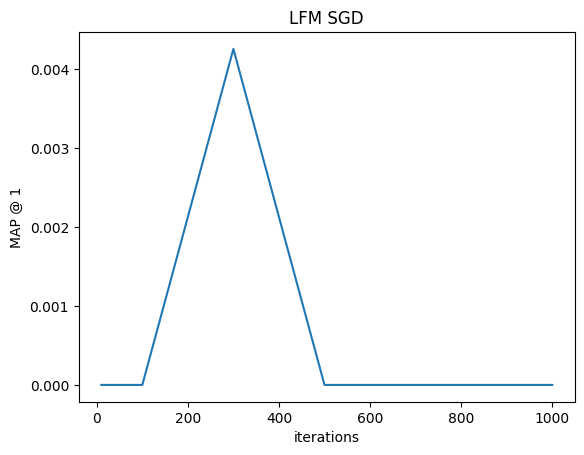

In [ ]:
plt.plot(n_iterations, for_plot)
plt.xlabel('iterations')
plt.ylabel('MAP @ 1')
plt.title('LFM SGD')

Видно, что в какой-то момент на тесте модель выходит на пик, затем уже начинает переобучаться и терять в качетсве

In [ ]:
n_iterations = (10, 15, 30, 50, 75) # для als уже нужно поменьше итераций, так как там происходит полное обращение
dims = np.arange(16, 257, 16)
best = 0
lfm_best_als = 0
best_k = []
best_dims = []
best_mapks_k = []
metrics_lfm_best_als = []
for i in n_iterations:
  for dim in dims:
    lfm = LatentFactorModel(train_ratings, dim, 'als')
    lfm.fit(i)
    lfm_recs = lfm.get_test_recommendations(100)
    mapk_i = 0
    metrics_lfm = []
    for k in k_n:
      recs_lfm_k = lfm_recs[:, : k]
      mapk_i += mapk(test_relevant, recs_lfm_k.tolist(), k)
      metrics_lfm.append(mapk(test_relevant, recs_lfm_k.tolist(), k))
      if mapk(test_relevant, recs_lfm_k.tolist(), k) > best_mapk_u2u:
        best_k.append(k)
        best_dims.append(dim)
        best_mapks_k.append(mapk(test_relevant, recs_lfm_k.tolist(), k))
    if mapk_i / len(k_n) > best:
      best = mapk_i / len(k_n)
      lfm_best_als = lfm
      metrics_lfm_best_als = metrics_lfm
      print(f'MAP: {best}, iters: {i}, dims: {dim}' )

  0%|          | 0/10 [00:00<?, ?it/s]

MAP: 0.00032589278044334145, iters: 10, dims: 16


  0%|          | 0/10 [00:00<?, ?it/s]

MAP: 0.0003314061591693259, iters: 10, dims: 32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

MAP: 0.0003318234234891055, iters: 10, dims: 96


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

MAP: 0.00033268662683404675, iters: 10, dims: 128


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

MAP: 0.0003334399336043857, iters: 15, dims: 64


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Здесь на ALS уже похуже

In [ ]:
for_plot = []
for i in n_iterations:
  lfm = LatentFactorModel(train_ratings, 64, 'als')
  lfm.fit(i)
  lfm_recs = lfm.get_test_recommendations(10)
  for_plot.append(mapk(test_relevant, lfm_recs.tolist(), 10))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Text(0.5, 1.0, 'LFM SGD')

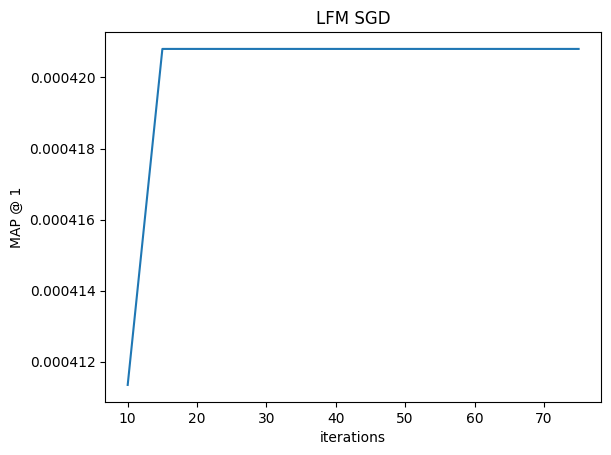

In [ ]:
plt.plot(n_iterations, for_plot)
plt.xlabel('iterations')
plt.ylabel('MAP @ 1')
plt.title('LFM SGD')

А здесь видим, что переобучения не возниикает, скорее всего, потому что каждый раз оптимизировали только по одной переменной, и вероятность перепрыгнуть оптимум гораздо меньше

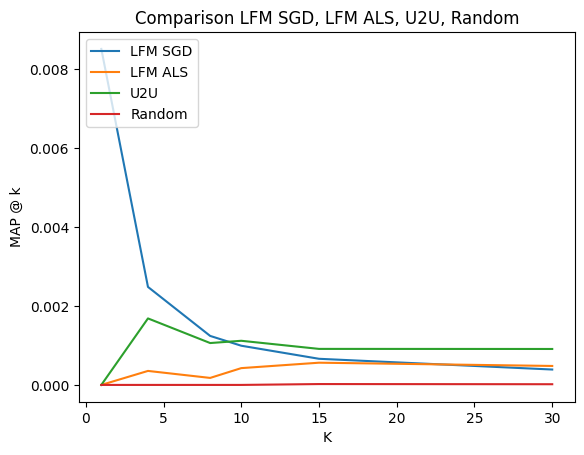

In [ ]:
plt.plot(k_n, metrics_lfm_best)
plt.plot(k_n, metrics_lfm_best_als)
plt.plot(k_n, metrics_u2u)
plt.plot(k_n, metrics_random)
plt.legend(['LFM SGD', 'LFM ALS', 'U2U', 'Random'], loc=2)
plt.xlabel('K')
plt.ylabel('MAP @ k')
plt.title('Comparison LFM SGD, LFM ALS, U2U, Random')
plt.show()

SGD показал более хорошие результаты, чем U2U, особенно на начальных k

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [15]:
model = LatentFactorModel(train_ratings, 112, 'sgd')
model.fit(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-14-e6112f06036e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch.drop_duplicates(subset=['userId'], keep='first', inplace=True) # короче за один шаг sgd, надо чтобы каждый вектор обновлялся один раз, поэтому не дожны в шаге повторяться треки или юзеры
<ipython-input-14-e6112f06036e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch.drop_duplicates(subset=['trackId'], keep='first', inplace=True)


In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
10935,Watercolour,['Pendulum'],0.369924
43449,Ветер,['Rickey F'],0.369619
44604,A Reason to Fight,['Disturbed'],0.367394
38398,Новый день,['Гражданская оборона'],0.350884
51800,Воин,['Sorta'],0.347613
54689,Gitar,['Пётр Налич'],0.343283
43876,Ты хочешь,['Миша Марвин'],0.340636
11045,I Just Died in Your Arms,['Savage'],0.339675
48824,Устал,['ЕГОР НАТС'],0.338182


**Бонус (1.5 балла).**

Постройте модель iALS и сравните ее качество с обучением ALS и SGD.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [16]:
u2u = User2User(train_ratings)
u2u_recs = u2u.get_test_recommendations(100)

<ipython-input-13-c005c2d731c5>:21: RuntimeWarning: divide by zero encountered in divide
  r_uid = (Nu_sim @ Nu_ratings)  / Nu_sim.sum()
<ipython-input-13-c005c2d731c5>:21: RuntimeWarning: invalid value encountered in divide
  r_uid = (Nu_sim @ Nu_ratings)  / Nu_sim.sum()


In [17]:
lfm_recs = model.get_test_recommendations(100)

**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [18]:
data = train_ratings.copy()
data['cos_dist'] = (model.P[data['userId']] * model.Q[data['trackId']]).sum(1) / np.linalg.norm(model.P[data['userId']], axis=1) / np.linalg.norm(model.Q[data['trackId']], axis=1)
sims = np.array([u2u.similarity(u2u.R[uid]) for uid in range(u2u.n_users)])
mean_sims = sims.mean(axis=1)
data['mean_Jaccard'] = mean_sims[data['userId']]
share_listened = u2u.R.mean(axis=0)
data['share_of_listened'] = share_listened[data['trackId']]
listened = u2u.R.sum(axis=1)
data['listened'] = listened[data['userId']]

In [19]:
data['last_50'] = 0

unique_users = data['userId'].unique()
for user in unique_users:
  user_indices = data[data['userId'] == user].index
  if len(user_indices) > 50:
    data.loc[user_indices[-50:], 'last_50'] = 1
  else:
    data.loc[user_indices, 'last_50'] = 1


In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['last_50'], axis=1), data['last_50'], test_size=0.4)
y_train.mean(), y_test.mean()

(0.09283635145926174, 0.09354352613886635)

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ).

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [21]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.6 MB/s eta 0:00:00


In [38]:
# надо немного причесать датасет, чтобы он был в подходящем формате для catboost
X_train['y_train'] = y_train
X_train = X_train.sort_index()
y_train = X_train['y_train']
X_train.drop(['y_train'], axis=1, inplace=True)

X_test['y_test'] = y_test
X_test = X_test.sort_index()
y_test = X_test['y_test']
X_test.drop(['y_test'], axis=1, inplace=True)

In [39]:
import catboost

# group_id == user_id here
train_group_id = X_train['userId']
test_group_id = X_test['userId']

train_pool = catboost.Pool(X_train, y_train, group_id=train_group_id)
test_pool = catboost.Pool(X_test, y_test, group_id=test_group_id)

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

In [40]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier(iterations=500, learning_rate=1e-1)
cb.fit(train_pool)

0:	learn: 0.5337103	total: 53.9ms	remaining: 26.9s
1:	learn: 0.4170456	total: 83.6ms	remaining: 20.8s
2:	learn: 0.3474921	total: 115ms	remaining: 19s
3:	learn: 0.3036696	total: 143ms	remaining: 17.7s
4:	learn: 0.2703024	total: 177ms	remaining: 17.5s
5:	learn: 0.2457009	total: 230ms	remaining: 18.9s
6:	learn: 0.2300358	total: 267ms	remaining: 18.8s
7:	learn: 0.2184604	total: 304ms	remaining: 18.7s
8:	learn: 0.2093402	total: 344ms	remaining: 18.8s
9:	learn: 0.2020911	total: 391ms	remaining: 19.2s
10:	learn: 0.1975400	total: 436ms	remaining: 19.4s
11:	learn: 0.1941331	total: 481ms	remaining: 19.6s
12:	learn: 0.1898917	total: 532ms	remaining: 19.9s
13:	learn: 0.1878356	total: 578ms	remaining: 20.1s
14:	learn: 0.1837663	total: 610ms	remaining: 19.7s
15:	learn: 0.1807136	total: 633ms	remaining: 19.1s
16:	learn: 0.1787447	total: 650ms	remaining: 18.5s
17:	learn: 0.1771026	total: 667ms	remaining: 17.9s
18:	learn: 0.1754190	total: 689ms	remaining: 17.4s
19:	learn: 0.1737774	total: 706ms	remaini

In [45]:
mask_pred = cb.predict(test_pool)
pred_recs = X_test[mask_pred == 1]
pred_relevant = []
pred_users = []
for user_id, user_data in pred_recs.groupby('userId'):
    pred_relevant += [pred_recs['trackId'].tolist()]
    pred_users.append(user_id)

In [54]:
test_recs = X_test[y_test == 1]
test_relevant_catboost = []
test_users_catboost = []
for user_id, user_data in test_recs.groupby('userId'):
    test_relevant_catboost += [test_recs['trackId'].tolist()]
    test_users_catboost.append(user_id)

In [60]:
u2u = User2User(train_ratings)
u2u_pred = u2u.get_test_recommendations(20)

<ipython-input-59-c005c2d731c5>:21: RuntimeWarning: divide by zero encountered in divide
  r_uid = (Nu_sim @ Nu_ratings)  / Nu_sim.sum()
<ipython-input-59-c005c2d731c5>:21: RuntimeWarning: invalid value encountered in divide
  r_uid = (Nu_sim @ Nu_ratings)  / Nu_sim.sum()


In [63]:
print(f'Catboost: {mapk(test_relevant_catboost, pred_relevant, 20)}')
print(f'U2U: {mapk(test_relevant, u2u_pred, 20)}')

Catboost: 0.6902260342856333
U2U: 0.0008243172833285476


**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.

In [65]:
from catboost import CatBoostRanker
cbr = CatBoostRanker(iterations=50)
cbr.fit(train_pool)

0:	total: 491ms	remaining: 24.1s
1:	total: 998ms	remaining: 23.9s
2:	total: 1.48s	remaining: 23.2s
3:	total: 1.97s	remaining: 22.7s
4:	total: 2.47s	remaining: 22.2s
5:	total: 2.96s	remaining: 21.7s
6:	total: 3.46s	remaining: 21.3s
7:	total: 3.95s	remaining: 20.7s
8:	total: 4.42s	remaining: 20.2s
9:	total: 4.92s	remaining: 19.7s
10:	total: 5.6s	remaining: 19.9s
11:	total: 6.4s	remaining: 20.3s
12:	total: 7.24s	remaining: 20.6s
13:	total: 8.11s	remaining: 20.9s
14:	total: 8.77s	remaining: 20.5s
15:	total: 9.26s	remaining: 19.7s
16:	total: 9.74s	remaining: 18.9s
17:	total: 10.2s	remaining: 18.2s
18:	total: 10.9s	remaining: 17.8s
19:	total: 11.7s	remaining: 17.5s
20:	total: 12.4s	remaining: 17.1s
21:	total: 12.9s	remaining: 16.4s
22:	total: 13.4s	remaining: 15.7s
23:	total: 13.9s	remaining: 15.1s
24:	total: 14.5s	remaining: 14.5s
25:	total: 15s	remaining: 13.8s
26:	total: 15.5s	remaining: 13.2s
27:	total: 16s	remaining: 12.6s
28:	total: 16.5s	remaining: 12s
29:	total: 17.1s	remaining: 11.4

In [66]:
cbr.predict(test_pool)

array([-1.03218832, -1.03218832, -1.03218832, ...,  2.14689395,
        2.14689395,  2.14689395])

В конце можно было сделать получше, но уже просто в ласт минуты доделывал, чисто символически сдать последнюю домашку ))

Вообще гораздо более хорошее качество показал catboost на classifier, на Ranker не успел осознать ((( Надеюсь можно будет потом дз просто показать ....